In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [15]:
df = pd.read_csv('data/data.csv', sep=';')

# # caso queira dividir em mais grupos pela situacao
# df.loc[(df['Nivel'] == 'Difficult') & (df['Situation'] == 'Open'), 'Nivel'] = 'Difficult Open'
# df.loc[(df['Nivel'] == 'Easy') & (df['Situation'] == 'Closed'), 'Nivel'] = 'Easy Closed'
# df.loc[(df['Nivel'] == 'Difficult') & (df['Situation'] == 'Closed'), 'Nivel'] = 'Difficult Closed'
# df.loc[(df['Nivel'] == 'Easy') & (df['Situation'] == 'Open'), 'Nivel'] = 'Easy Open'
# df.drop(columns=['Situation'], inplace=True)

print(df.info())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Situation             1107 non-null   object
 1   Nivel                 1107 non-null   object
 2   Number                1107 non-null   int64 
 3   Imports               1107 non-null   int64 
 4   Changed_files         1107 non-null   int64 
 5   Changes               1107 non-null   int64 
 6   Deletion              1107 non-null   int64 
 7   Aditions              1107 non-null   int64 
 8   Size_body             1107 non-null   int64 
 9   Create_date           1107 non-null   object
 10  Closed_date           1016 non-null   object
 11  Merge_date            203 non-null    object
 12  Diff_MergeLastModify  203 non-null    object
 13  Diff_CreateNow        1107 non-null   object
 14  PR_comments           1107 non-null   int64 
 15  PR_size_comments      1107 non-null   

,Situation,Nivel,Number,Imports,Changed_files,Changes,Deletion,Aditions,Size_body,Create_date,...,Diff_MergeLastModify,Diff_CreateNow,PR_comments,PR_size_comments,Review_comments,Review_size_comments,Issue_comments,Issue_size_comments,Qtd_labels,Commits
0,Open,Difficult,19975,0,5,27,7,20,1100,2021-10-15 13:15:02,...,NaN,38 days 01:50:19.823749,8,1086,5,1086,7,1752,3,1
1,Open,Difficult,18481,7,1,5,1,4,157,2021-05-13 18:48:06,...,NaN,192 days 20:17:18.138159,0,0,0,0,0,0,1,1
2,Open,Difficult,17329,12,10,427,37,390,81,2021-02-17 07:57:13,...,NaN,278 days 07:08:14.990736,4,2598,8,2598,3,516,2,4
3,Open,Difficult,16746,2,11,870,6,864,47,2020-11-14 01:13:08,...,NaN,373 days 13:52:23.771179,11,3886,14,3886,10,5529,3,3
4,Open,Difficult,16555,1,15,106,46,60,334,2020-10-16 18:16:06,...,NaN,401 days 20:49:28.112162,5,0,0,0,3,525,2,4


In [16]:
# separar os dados em faceis/difíceis
dfEasy = df.loc[df['Nivel'] == 'Easy']
dfDifficult = df.loc[df['Nivel'] == 'Difficult']

# pego a mesma quantidade de dados dos difíceis
dfEasy = dfEasy[:len(dfDifficult)]

dfPart = pd.concat([dfEasy, dfDifficult])
df = dfPart

In [17]:
df = df.drop(columns=['Number', 'Closed_date', 'Merge_date', 'Diff_MergeLastModify', 'Create_date', 'Diff_CreateNow'])

# dfOpen = df.loc[df['Situation'] == 'Open']
# dfClosed = df.loc[df['Situation'] == 'Closed']

In [21]:
def changeValue(df, columns=['Situation', 'Nivel'], values=[['Open', 'Closed'], ['Difficult', 'Easy']]):
    for idx, column in enumerate(columns):
        df.loc[df[column] == values[idx][0], column] = 1
        df.loc[df[column] == values[idx][1], column] = 0

def returnValue(df, columns=['Situation', 'Nivel'], values=[['Open', 'Closed'], ['Difficult', 'Easy']]):
    for column in columns:
        df.loc[df[column] == 1, column] = values[idx][0]
        df.loc[df[column] == 0, column] = values[idx][1]

# y = np.array(df['Nivel'].values.tolist())
y = df['Nivel'].values.tolist()

changeValue(df)

X = df.values

scaler = StandardScaler()
scaler.fit(X)

X = scaler.transform(X)

df = pd.DataFrame(X, columns=df.columns)
df['Nivel'] = y
df

,Situation,Nivel,Imports,Changed_files,Changes,Deletion,Aditions,Size_body,PR_comments,PR_size_comments,Review_comments,Review_size_comments,Issue_comments,Issue_size_comments,Qtd_labels,Commits
0,0.715678,Easy,-0.559734,-0.562372,-0.406439,-0.519988,-0.351174,-0.137339,-1.023891,-0.480213,-0.575917,-0.480213,-0.886515,-0.582753,-1.008670,-0.211547
1,0.715678,Easy,0.383296,-0.726839,-0.439346,-0.423463,-0.395533,-0.788785,-0.851855,-0.480213,-0.575917,-0.480213,-0.709782,-0.554192,-1.008670,0.089968
2,0.715678,Easy,-0.559734,-0.726839,-0.435689,-0.519988,-0.380746,-0.166410,-1.023891,-0.480213,-0.575917,-0.480213,-0.886515,-0.582753,-1.008670,-0.513063
3,0.715678,Easy,-0.559734,-0.397905,-0.402783,-0.359113,-0.365960,-0.391047,0.352396,-0.480213,-0.575917,-0.480213,0.527348,0.693077,-1.008670,0.089968
4,0.715678,Easy,-0.559734,-0.233437,-0.347938,-0.455638,-0.299422,-0.416153,0.008324,-0.480213,-0.575917,-0.480213,0.173882,-0.072638,-1.008670,-0.211547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,-1.397276,Difficult,3.400990,2.069104,0.361384,-0.455638,0.417712,-0.482223,0.008324,-0.381185,-0.242986,-0.381185,-0.356316,0.114272,-1.008670,-0.211547
120,-1.397276,Difficult,-0.559734,0.424432,-0.326000,0.059160,-0.336388,-0.668539,-0.335747,-0.480213,-0.575917,-0.480213,-0.533049,-0.423319,-0.432287,-0.513063
121,-1.397276,Difficult,-0.559734,0.095497,0.522261,1.249632,0.384443,-0.656646,0.524432,-0.480213,-0.575917,-0.480213,0.704081,0.272259,-1.008670,0.391484
122,-1.397276,Difficult,-0.559734,-0.726839,-0.443002,-0.552163,-0.384443,-0.586613,0.352396,-0.245105,-0.409451,-0.245105,0.173882,-0.391143,1.873244,-0.513063


In [ ]:
y = df['Nivel'].to_list()
X = df.drop(columns=['Nivel'])

# X_treino, X_val, y_treino, y_val = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=1)

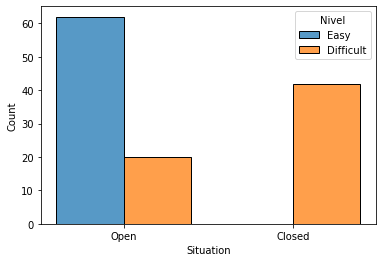

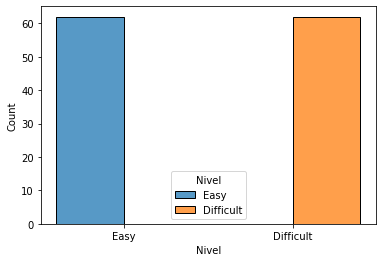

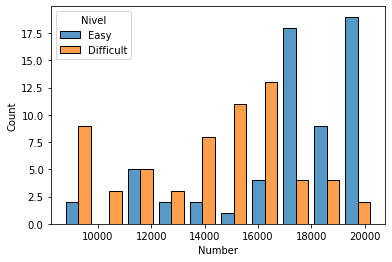

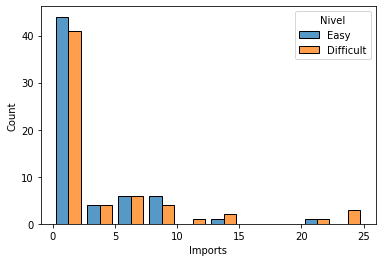

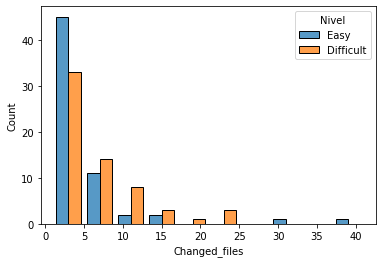

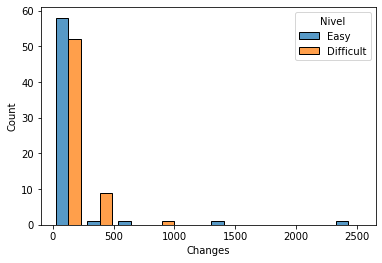

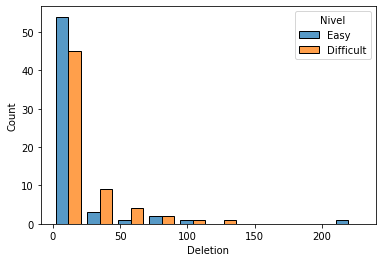

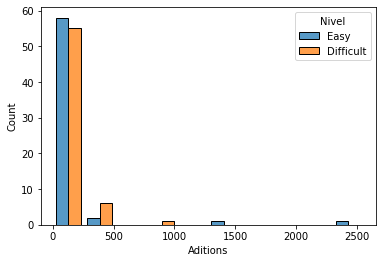

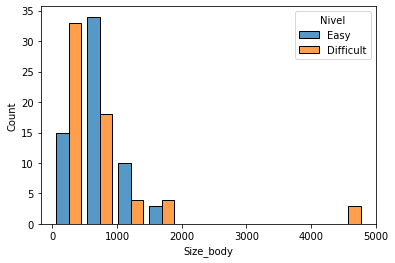

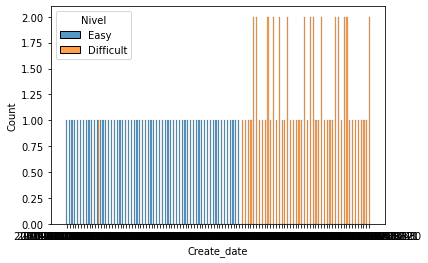

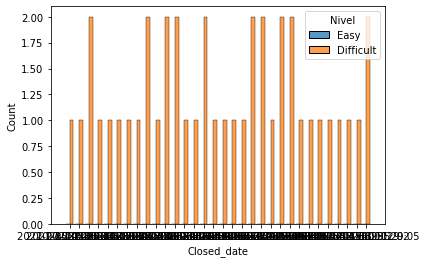

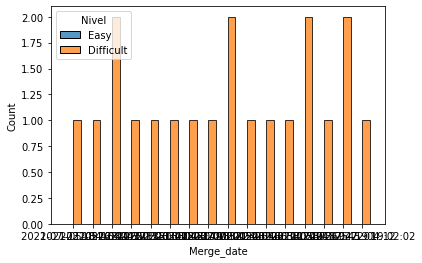

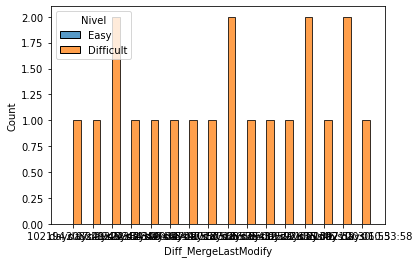

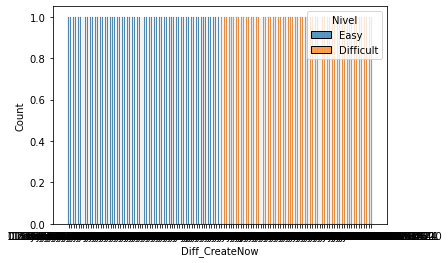

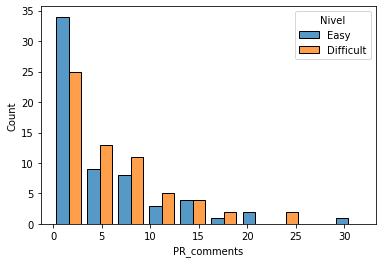

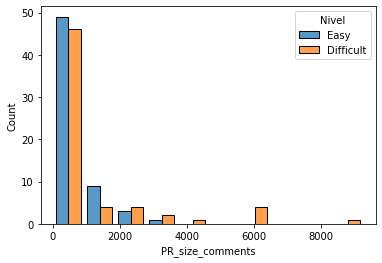

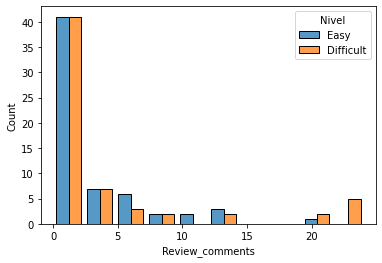

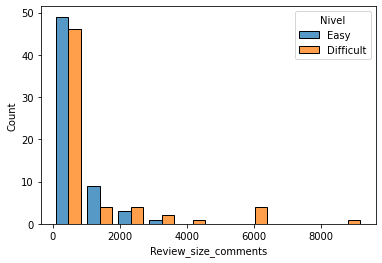

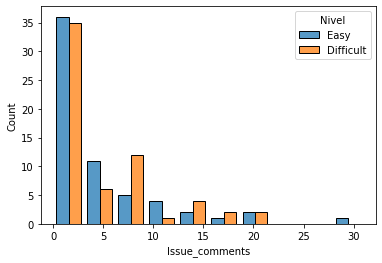

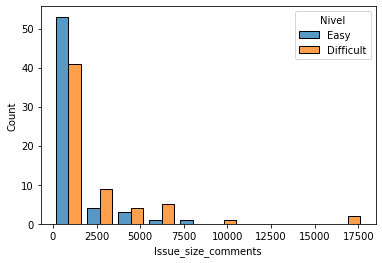

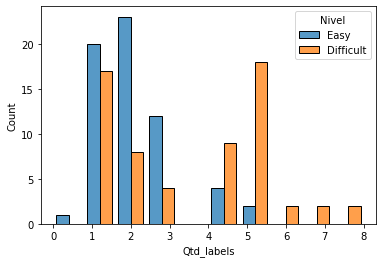

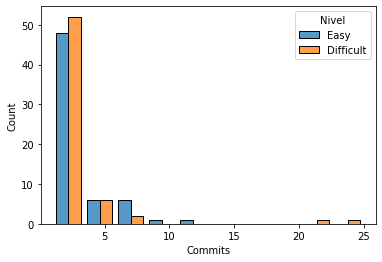

In [43]:
for idx, column in enumerate(df.columns):
    sns.histplot(data=df, bins=10, x=column, hue='Nivel', multiple='dodge', shrink=0.8)
    plt.show()

In [20]:
df.groupby('Nivel').describe()

Imports                                                 \
            count      mean       std  min  25%  50%   75%   max   
Nivel                                                              
Difficult    62.0  3.661290  6.319223  0.0  0.0  0.0  6.00  25.0   
Easy         62.0  2.274194  4.029275  0.0  0.0  0.0  3.75  20.0   

          Changed_files            ... Qtd_labels      Commits            \
                  count      mean  ...        75%  max   count      mean   
Nivel                              ...                                     
Difficult          62.0  5.919355  ...        5.0  8.0    62.0  2.709677   
Easy               62.0  4.919355  ...        3.0  5.0    62.0  2.693548   

                                                
                std  min  25%  50%   75%   max  
Nivel                                           
Difficult  4.130602  1.0  1.0  1.5  2.75  25.0  
Easy       2.301736  1.0  1.0  2.0  3.00  12.0  

[2 rows x 112 columns]

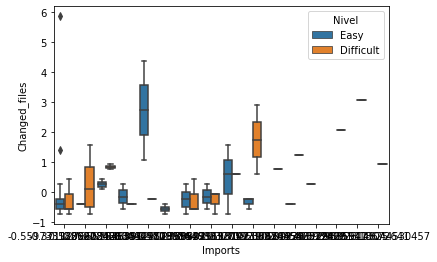

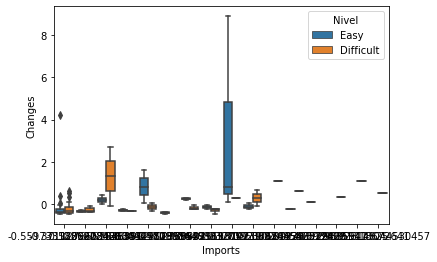

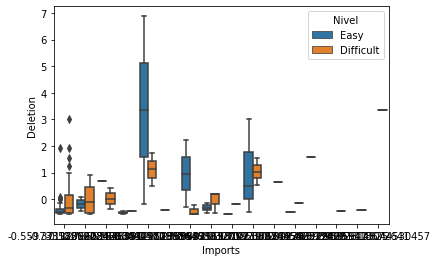

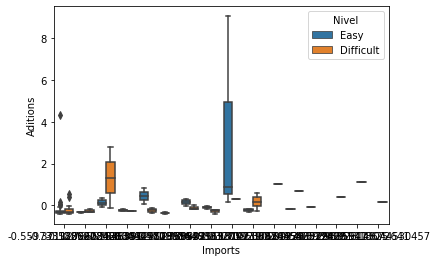

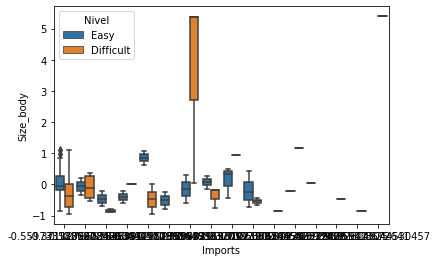

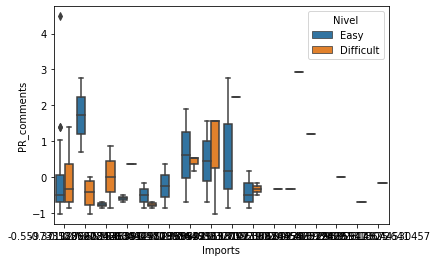

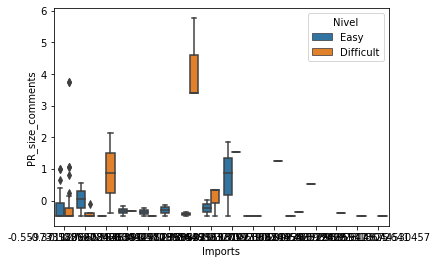

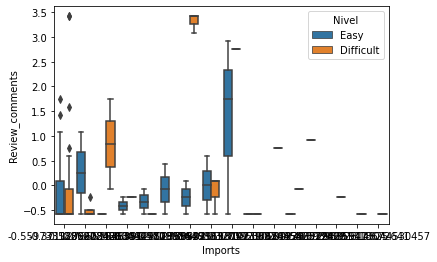

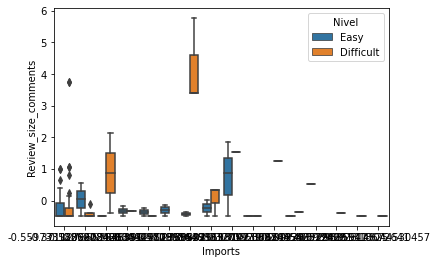

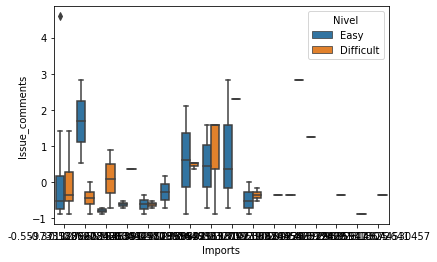

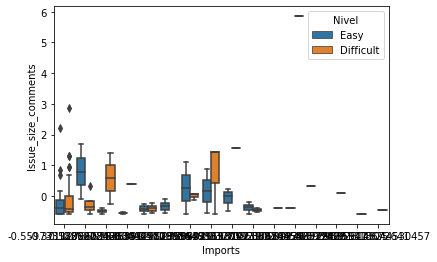

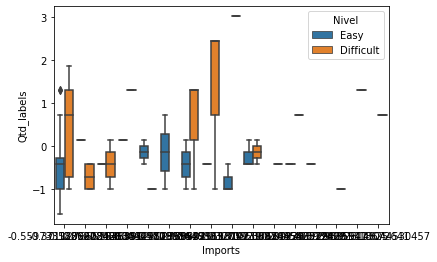

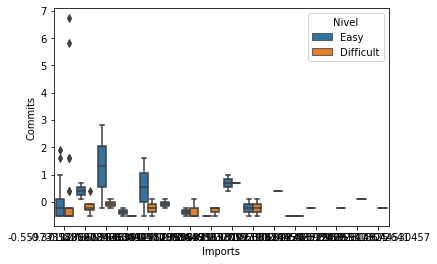

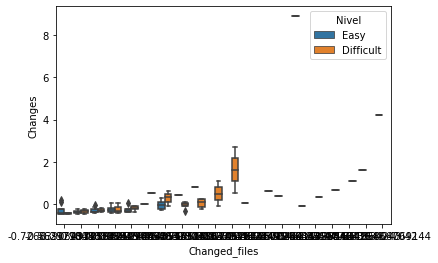

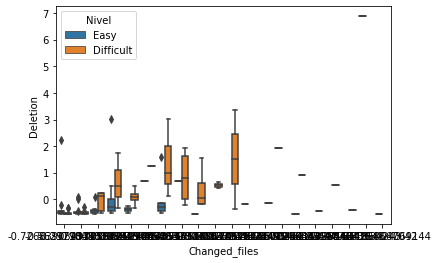

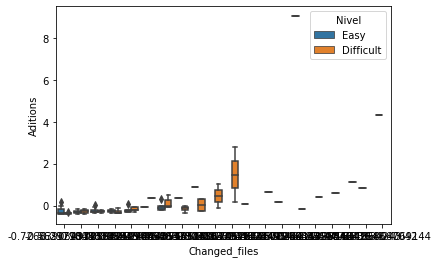

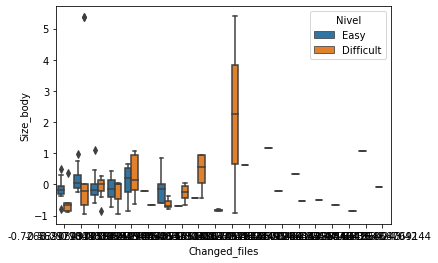

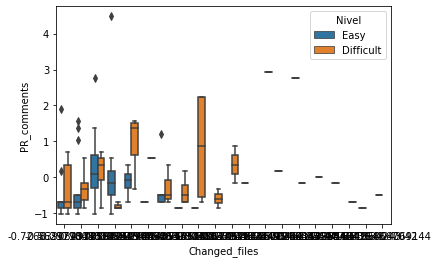

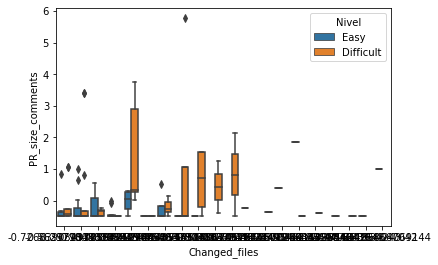

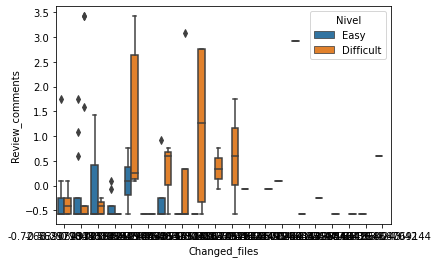

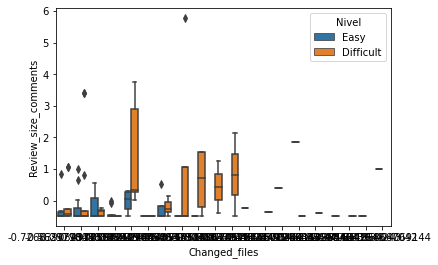

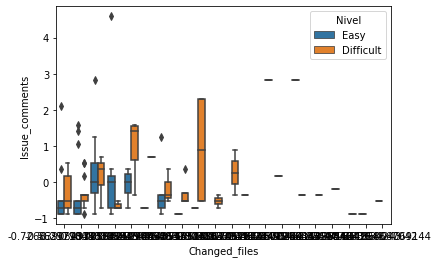

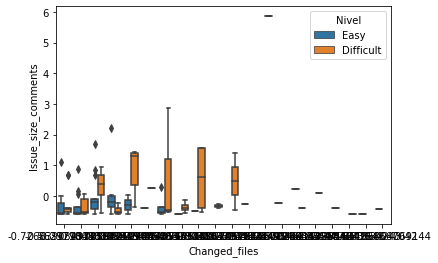

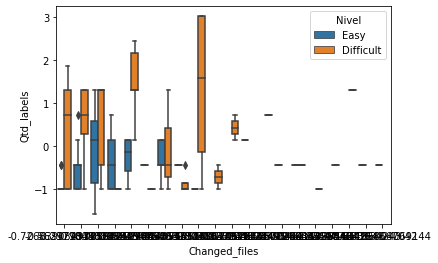

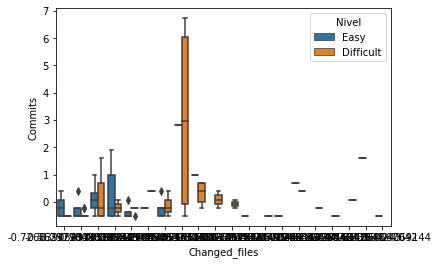

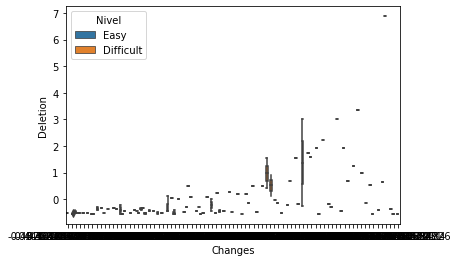

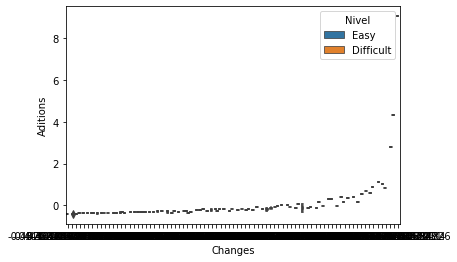

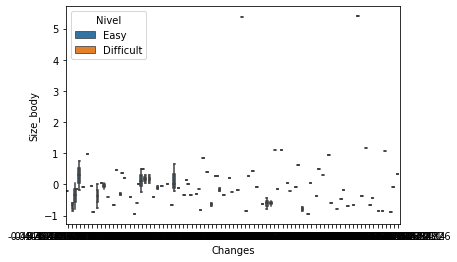

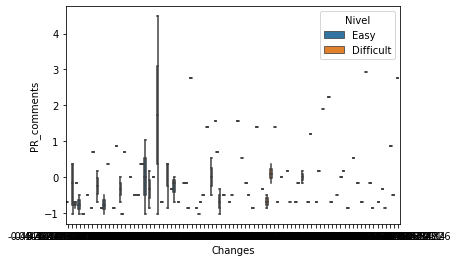

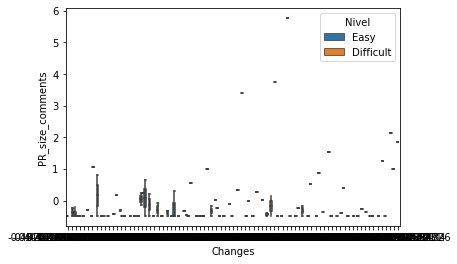

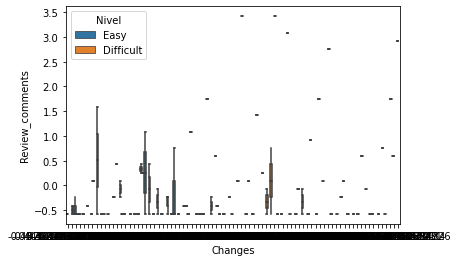

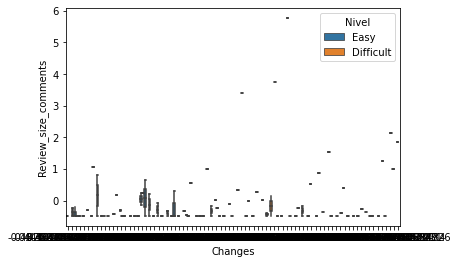

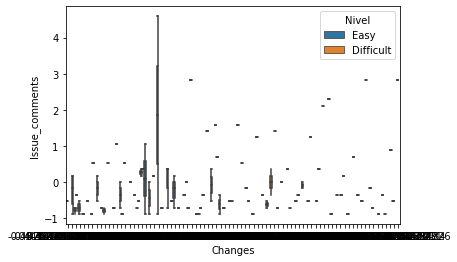

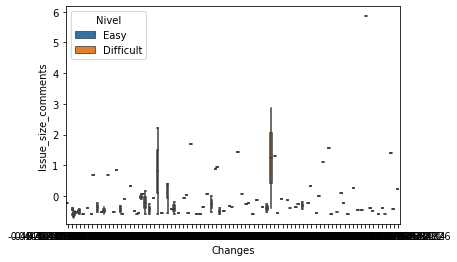

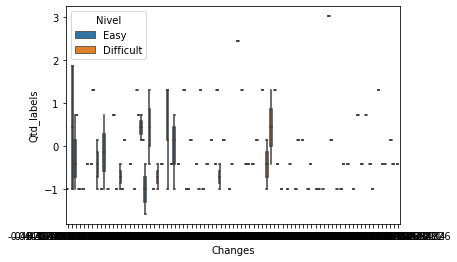

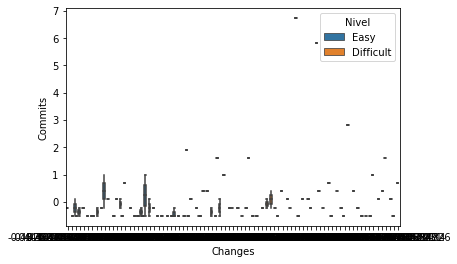

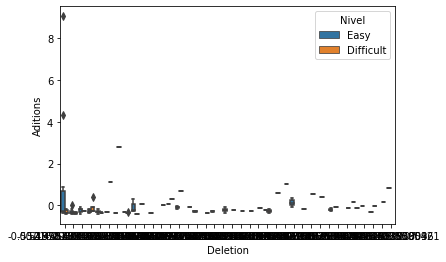

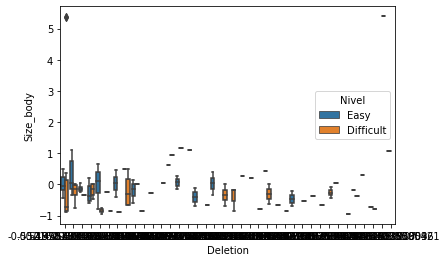

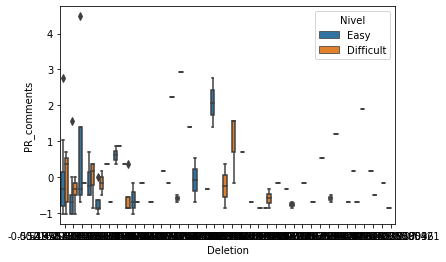

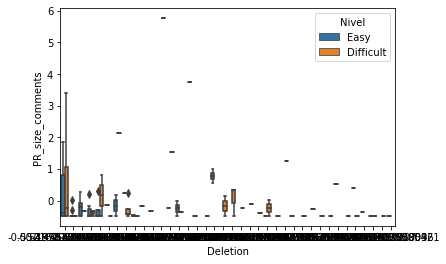

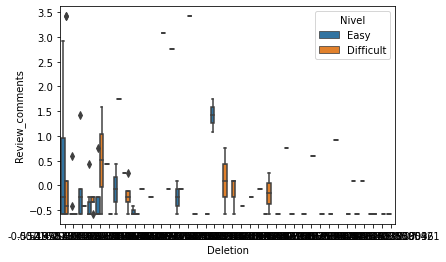

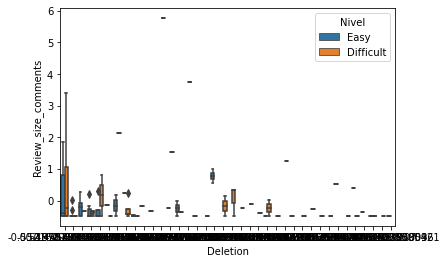

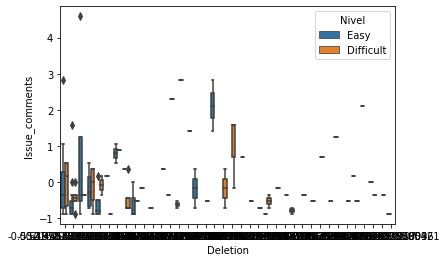

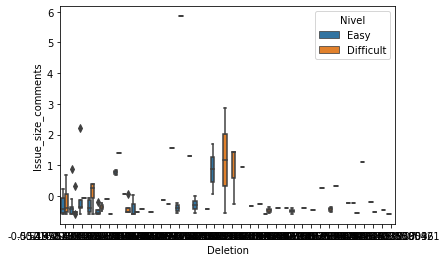

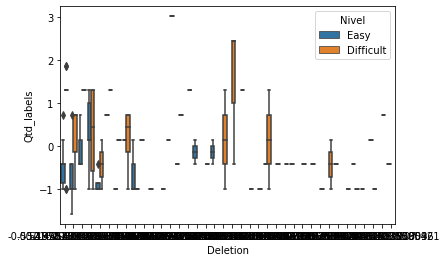

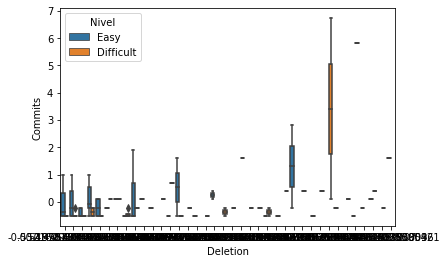

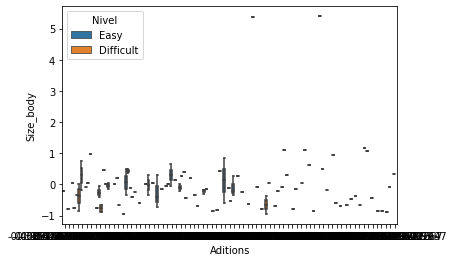

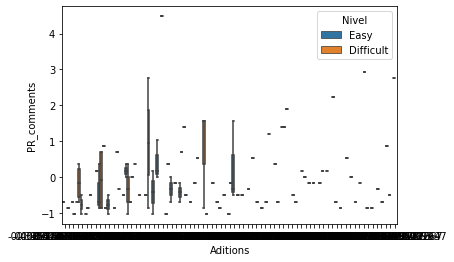

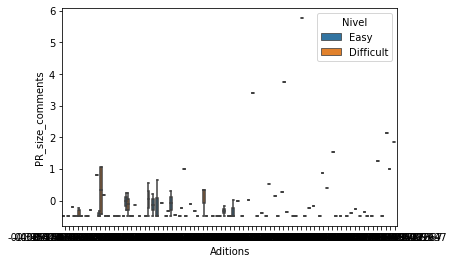

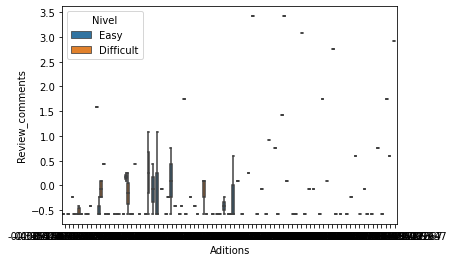

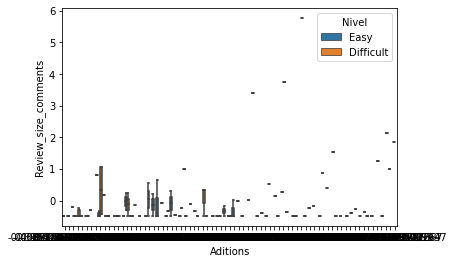

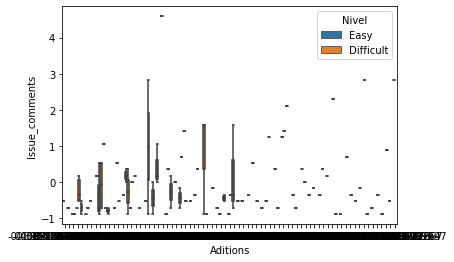

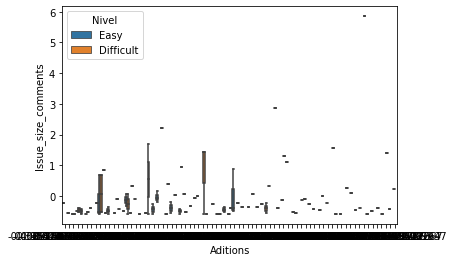

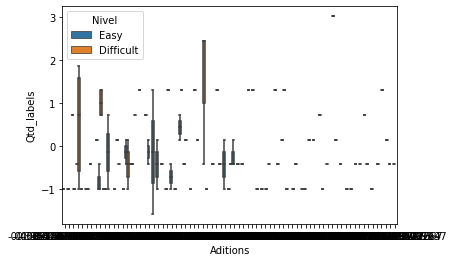

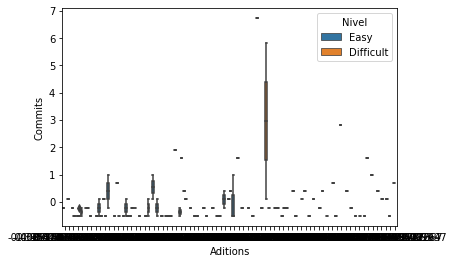

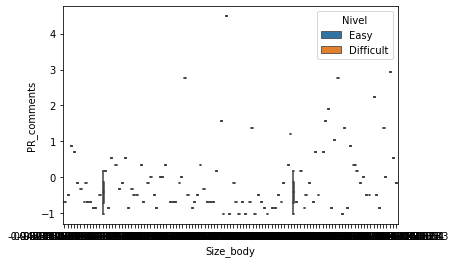

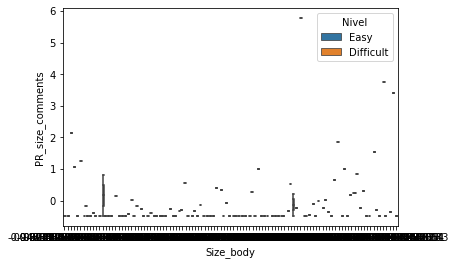

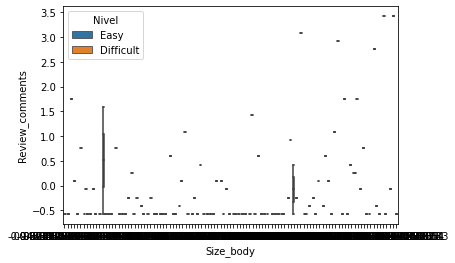

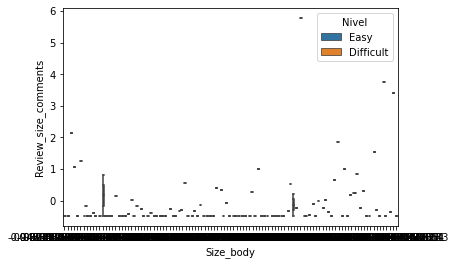

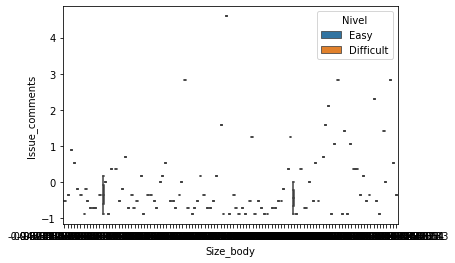

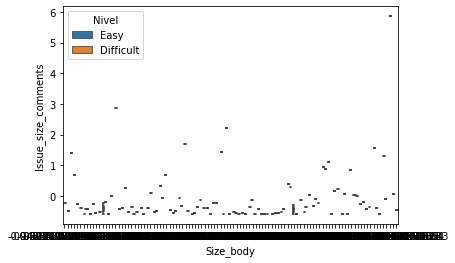

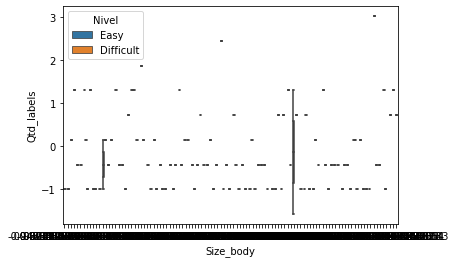

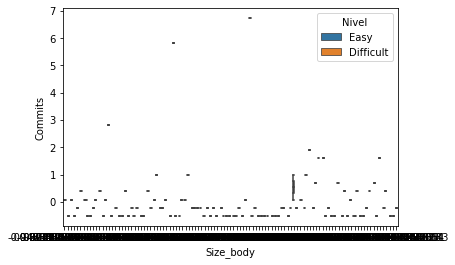

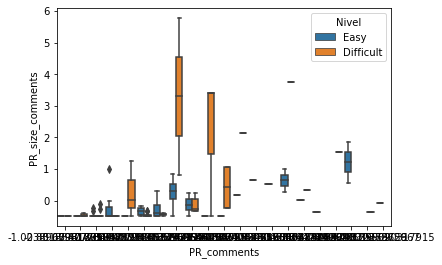

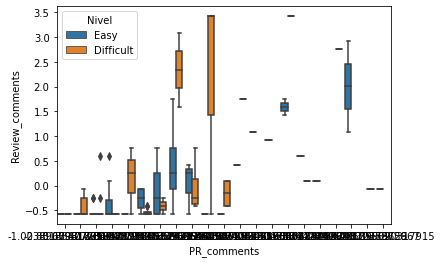

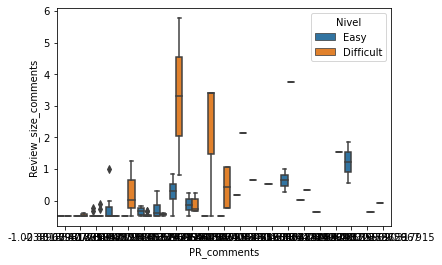

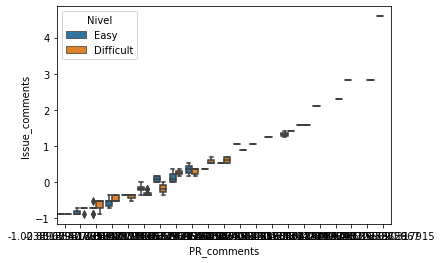

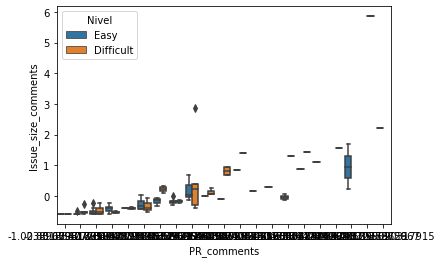

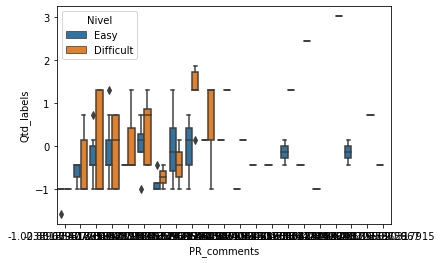

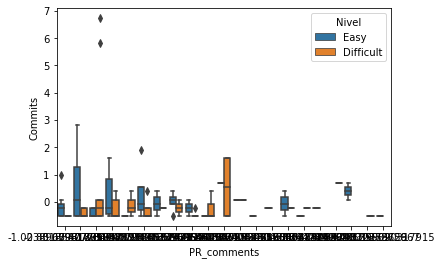

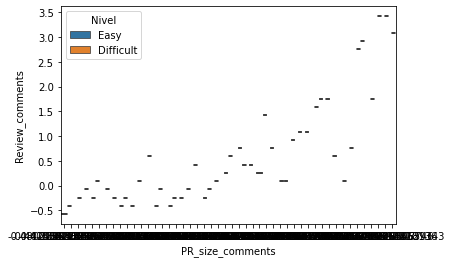

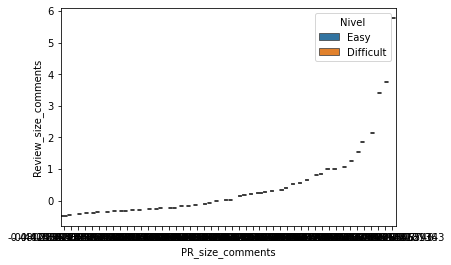

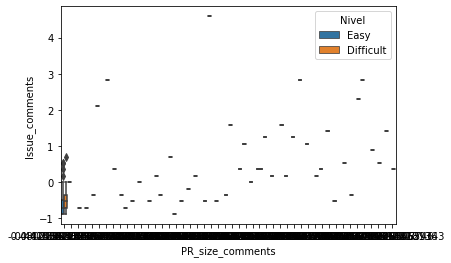

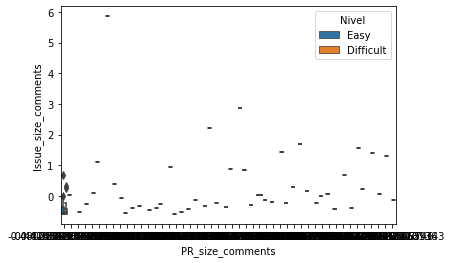

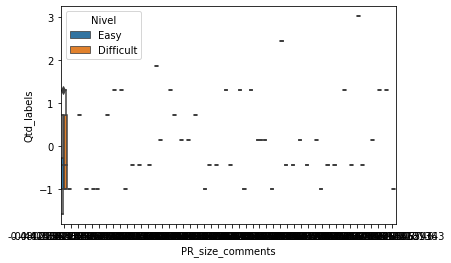

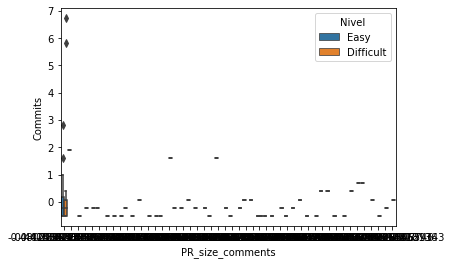

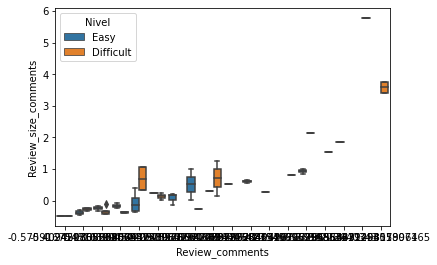

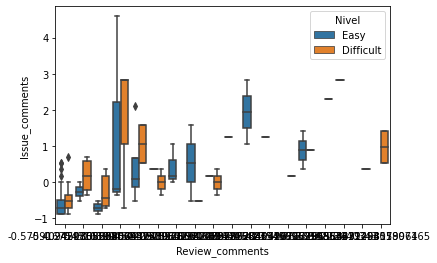

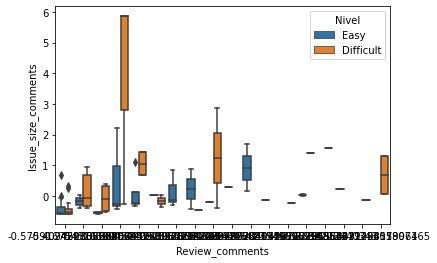

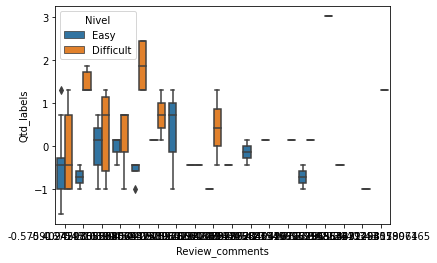

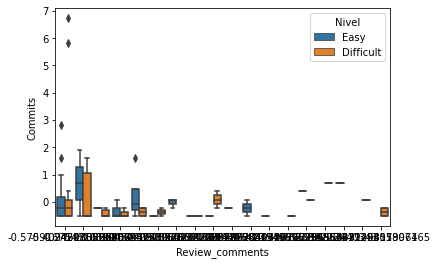

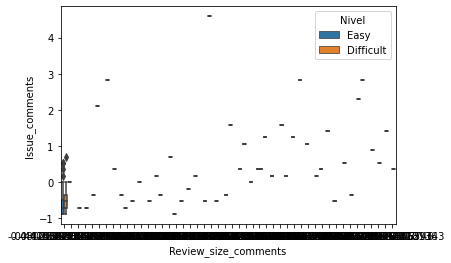

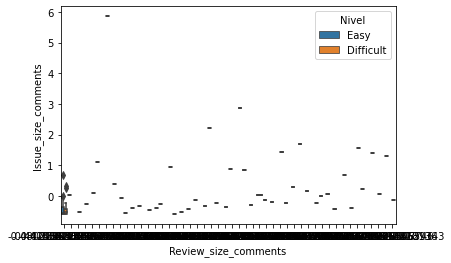

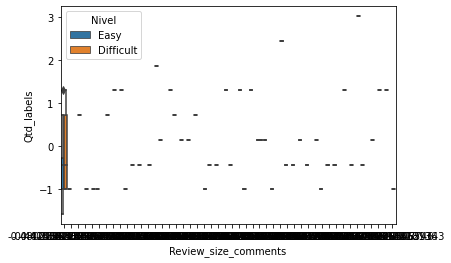

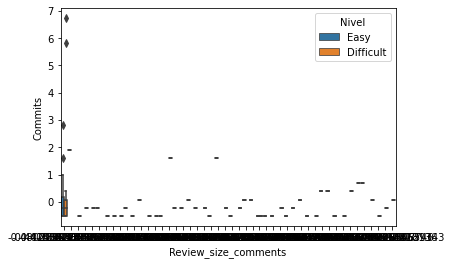

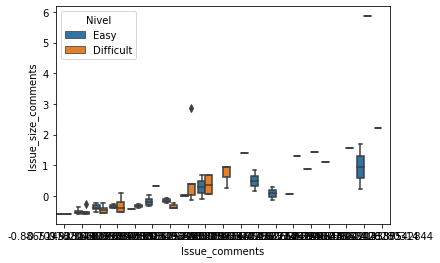

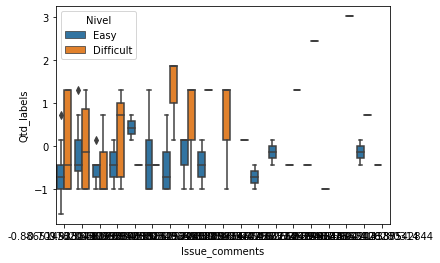

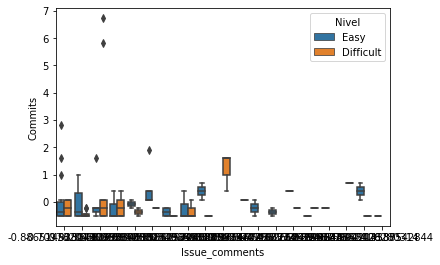

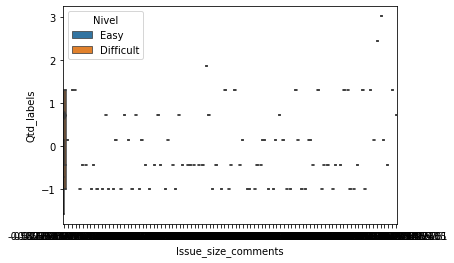

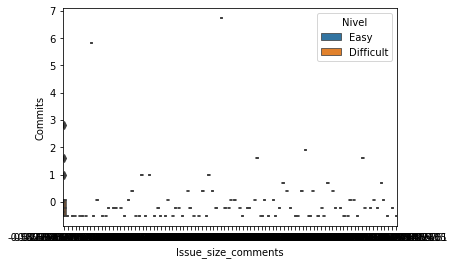

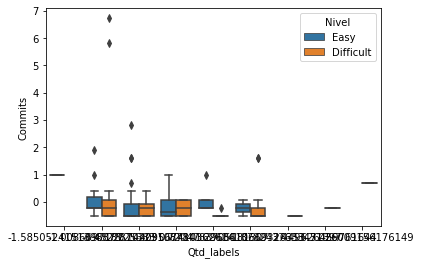

In [22]:
# columns = [['Commits', 'Issue_comments'], ['Qtd_labels', 'Commits'], ['Qtd_labels', 'Issue_comments']]
columns = ['Imports', 'Changed_files', 'Changes', 'Deletion','Aditions', 'Size_body', 'PR_comments', 'PR_size_comments','Review_comments', 'Review_size_comments', 'Issue_comments','Issue_size_comments', 'Qtd_labels', 'Commits']

for idx, column in enumerate(columns):
    for columnAgn in columns[idx+1:]:
        sns.boxplot(data=df, x=column, y=columnAgn, hue='Nivel')
        plt.show()